In [8]:
import numpy as np
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models import DiodeModel
from src.extraction import ModelExtractor
from src.visualization import *

from scipy.constants import k as k_B, e as q_e
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import plotly.graph_objects as go

## Single Temperature Diode Fit Demo

For single-temperature diode I-V data, the parameters are extracted at a constant temperature (300K). The Schokley diode equation is used to find these parameters, alongside an additional term to account for the series resistance.

$$ I = I_s \left( \exp \left( \frac{V - I \cdot R_s}{n \cdot V_t} \right) - 1 \right) $$

This extraction uses a non-linear least squares optimization algorithm to minimize the difference between the measured current and the current predicted by the model. The parameters $I_s$ and $n$ are mostly determined by the exponential region of the I-V curve, while $R_s$ is found using the high-voltage region where the curve begins to become more linear.

True parameters: {'I_s': 1e-10, 'n': 1.5, 'R_s': 2.5}
Fitted parameters: {'I_s': 9.945024972440975e-11, 'n': 1.5002339924406982, 'R_s': 2.4600195007292793}
RMS err: 0.01954930157623983


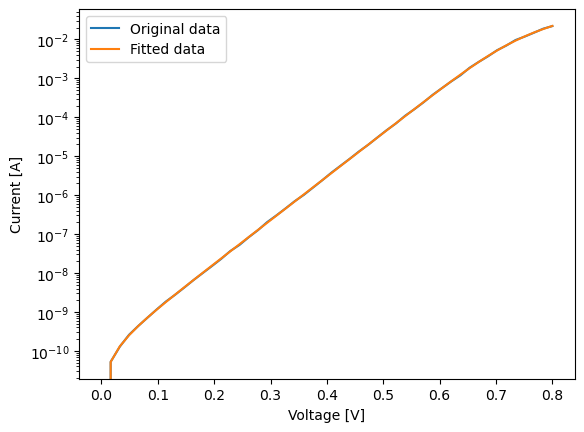

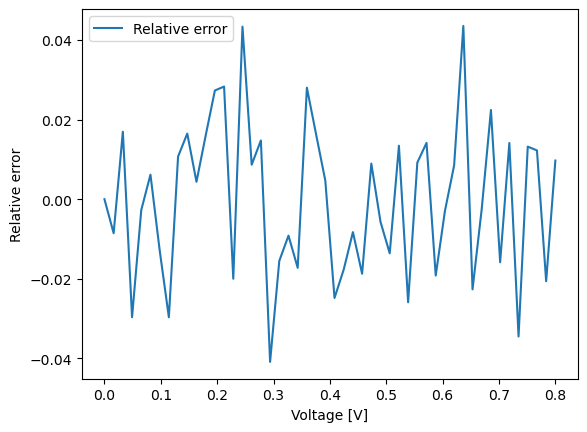

In [9]:
model = DiodeModel()
extractor = ModelExtractor(model)

true_params = {
    'I_s': 1e-10, 
    'n': 1.5, 
    'R_s': 2.5
}

T_test = 300
V_data = np.linspace(0, 0.8, 50)
I_true = model.compute_current(V_data, true_params, T=T_test)

np.random.seed(67)
I_noise = I_true * (1 + np.random.normal(0, 0.02, size=I_true.shape))

initial_guess = {'I_s': 1e-11, 'n': 1.4, 'R_s': 0.1}
report = extractor.diode_fit(V_data, I_noise, T=T_test, initial_params=initial_guess)

print("True parameters:", true_params)
print("Fitted parameters:", report['parameters'])
print("RMS err:", report['rms_err'])

plot_diode_fit(V_data, I_noise, model, report['parameters'])
diode_error_plot(V_data, I_noise, model, report['parameters'])

## Multi-Temperature Diode Fit Demo

For multi-temperature diode I-V data, I extracted the global parameters that describe the diode's behavior across a range of temperatures. Instead of fitting $I_s$ individually for each temperature, we fit the bandgap energy $E_g$, which allows for the model to predict $I_s$ at any temperature using the physics-based scaling law:

$$ I_s(T) = I_{s,ref} \left( \frac{T}{T_{ref}} \right)^3 \exp \left[ \frac{E_g \cdot q}{k_B} \left( \frac{1}{T_{ref}} - \frac{1}{T} \right) \right] $$

The goal of this demo is to demonstrate how the program can find a single set of parameters [$I_s$, $n$, $R_s$, and $E_g$] that matches the behavior observed by the diode I-V data across multiple temperatures while minimzing any errors.

True global: {'I_s': 1e-08, 'Eg': 1.5, 'n': 1.72, 'R_s': 8}
Fitted global: {'I_s': 9.951570354245756e-09, 'Eg': 1.5009104715243957, 'n': 1.7196705633789116, 'R_s': 7.975659003559486}
Global RMS err: 0.019553300152325478


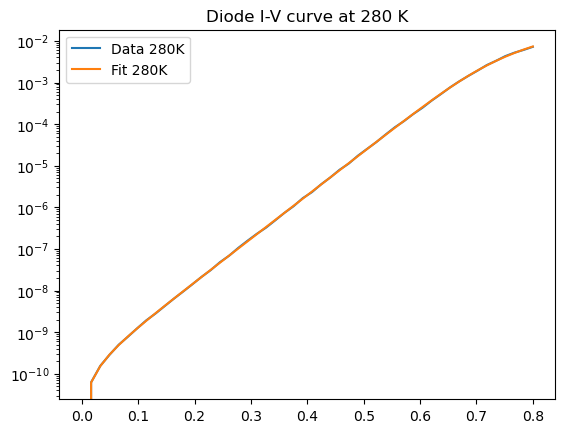

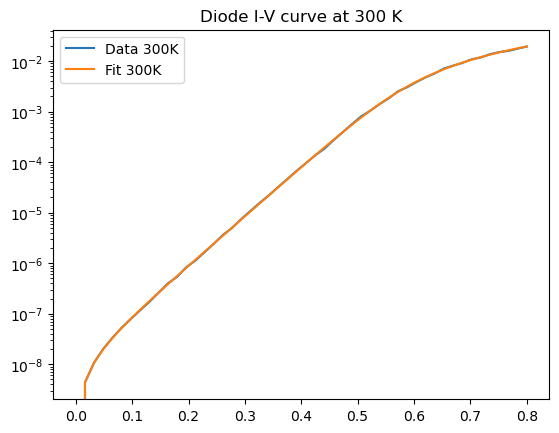

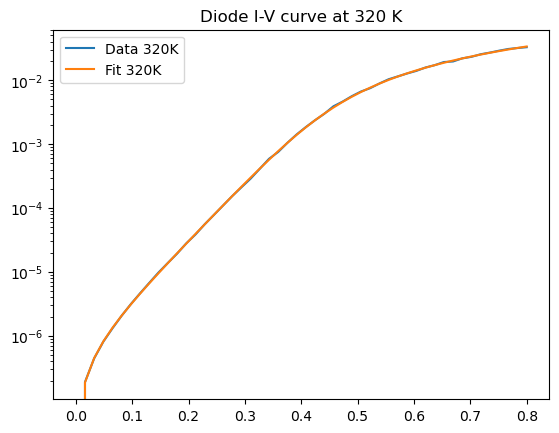

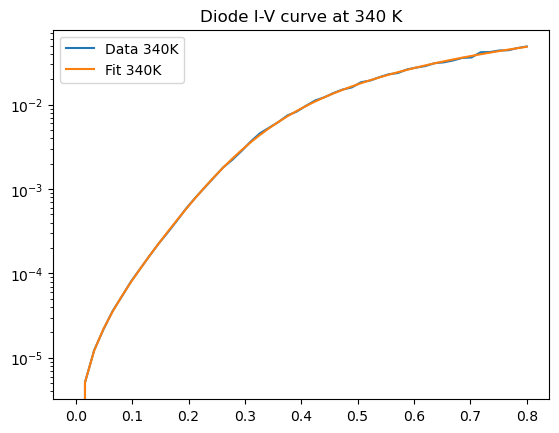

In [10]:
T_ref = 300
true_global = {
    'I_s': 1e-8, 
    'Eg': 1.5, 
    'n': 1.72, 
    'R_s': 8
}

def Is_at_T(T):
    Is_ref = true_global['I_s']
    Eg = true_global['Eg']
    return Is_ref * (T / T_ref)**3 * np.exp(((Eg * q_e) / k_B) * (1/T_ref - 1/T))

temps = [280, 300, 320, 340]
V_sweep = np.linspace(0, 0.8, 50)
datasets = []

np.random.seed(41)

for T in temps:
    Is_local = Is_at_T(T)
    local_params = {
        'I_s': Is_local,
        'n': true_global['n'],
        'R_s': true_global['R_s']
    }
    I_ideal = model.compute_current(V_sweep, local_params, T=T)
    I_noise = I_ideal * (1 + np.random.normal(0, 0.02, size=I_ideal.shape))
    datasets.append((V_sweep, I_noise, T))
    
initial_global = {
    'I_s': 1e-11,
    'Eg': 1.0,
    'n': 1.2,
    'R_s': 0.1
}

report = extractor.diode_temp_fit(datasets, initial_params=initial_global)
fit_global = report['parameters']

print('True global:', true_global)
print('Fitted global:', fit_global)
print('Global RMS err:', report['rms_err'])

V_list = [d[0] for d in datasets]
I_list = [d[1] for d in datasets]

plot_diode_fit(V_list, I_list, model, fit_global, temps=temps)

## Multi-Temperature Diode Error Analysis

The relative error can be calculated by taking the fitted data found through the least-squares algorithm and comparing it to the actual data values. We can then plot this against the voltage points to see the relative error values at each voltage value.

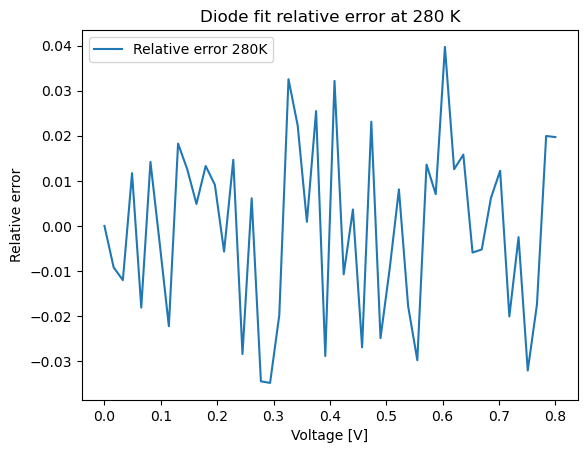

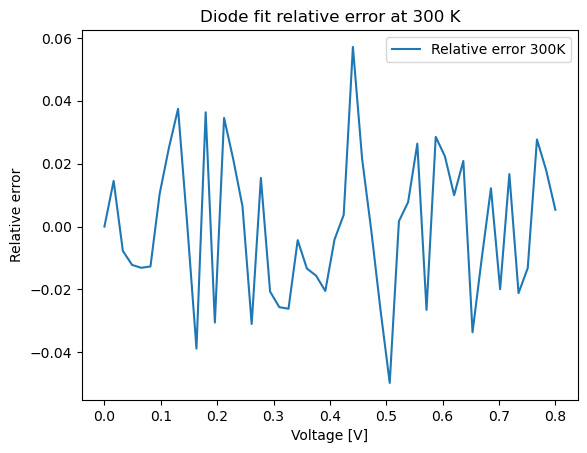

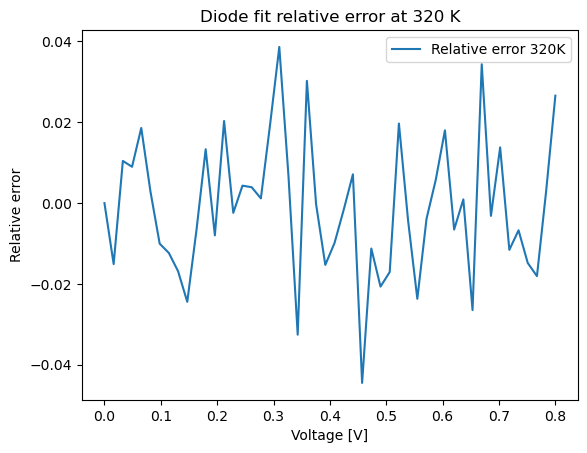

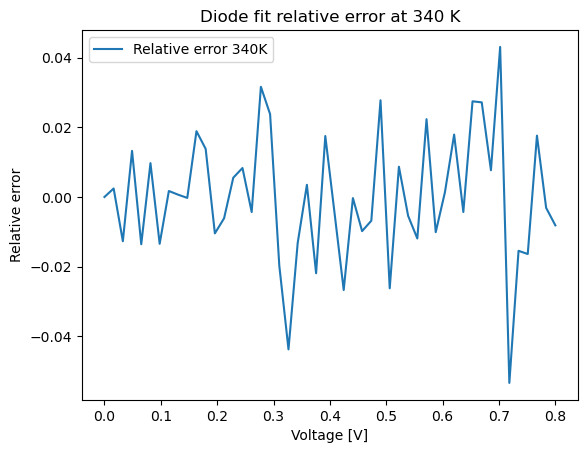

In [11]:
diode_error_plot(V_list, I_list, model, fit_global, temps=temps)

## Multi-Temperature Diode Saturation Current vs Temperature Plot

The saturation current is highly sensitive to temperature because it depends on the square of the intrinsic carrier concentration. The relationship used in this model to scale $I_s$ from a reference temperature to a target tempeature is given by the equation from earlier.

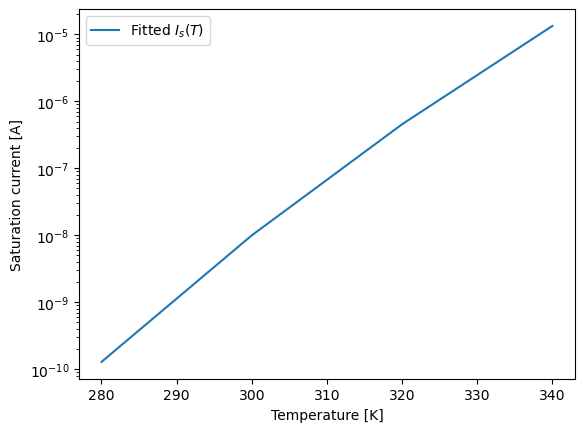

In [12]:
diode_sat_current_plot(temps, model, fit_global)

## Interactive Diode Visualization

The physical operation of the extracted diode model can be visualized by adjusting the biased voltage across the device using sliders. A cross section of a typical diode is drawn and, based on the value of the slider and the parameters of the device, the depletion region will change width and the device will go between equilibrium, forward, and reverse bias states.

In [16]:
params = report['parameters']

@interact(
    v_bias=FloatSlider(min=-1.5, max=1.5, step=0.1, value=1.0, description='V_bias [V]')
)

def view_channel(v_bias):
    fig, ax = plt.subplots(figsize=(6, 4))
    draw_diode_cross(ax, params, v_bias)

interactive(children=(FloatSlider(value=1.0, description='V_bias [V]', max=1.5, min=-1.5), Output()), _dom_cla…

## 3D Characteristic Surface

A 3D plot can be generated to get a full picture of the relationship between current, voltage and temperature within the extracted diode model over its entire operating range.

In [17]:
fig = plot_3d_diode(model, params)
fig.show()

<Figure size 1000x700 with 0 Axes>